<a href="https://colab.research.google.com/github/Jonalismus/Beleg2_Bildverarbeitung/blob/master/MTG_Winrate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problemstellung**

Optimierung der Kartenauswahl für ein Magic: The Gathering Limited Deck.


---



 **Zielstellung:** Entwicklung eines Machine-Learning-Modells zur Vorhersage der erwarteten Gewinnrate (Games in Hand Win Rate) von Karten auf Grundlage historischer Leistungsdaten und spielbezogener Merkmale. Das Modell soll in der Lage sein, die Gewinnrate neu veröffentlichter Karten basierend auf deren  Eigenschaften vorherzusagen. Dadurch soll es ermöglicht werden, bereits bei einem Pre-Release-Event zu erkennen, welche Karten voraussichtlich eine hohe Performance aufweisen, ohne dass hierfür bereits Spieldaten gesammelt wurden.



---


### **2. Datenbeschaffung**

**Datensatz 1:**

**Datenquelle und Beschreibung:**
Die in diesem Projekt verwendeten Daten stammen von der Magic: The Gathering API (https://docs.magicthegathering.io/). Diese API stellt umfassende Informationen zu den verschiedenen Karten im JSON Format bereit. Sowie von 17Lands (https://www.17lands.com/card_data?expansion=MOM&format=PremierDraft&start=2023-04-18&sort=name%2Casc). 17Lands sammelt umfangreiche Spieldaten von MTG-Spielern und stellt diese Daten zur Verfügung, um Analysen und Einblicke in die Leistung von Karten und Decks zu ermöglichen.



---


**Beispielhafte Ausgabe einer Karte**:

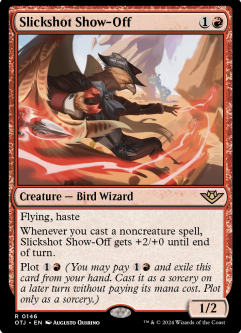

In [ ]:
{
  "cards":[
      {
      "name":"Archangel Avacyn",
      "names":[
          "Archangel Avacyn",
          "Avacyn, the Purifier"
      ],
      "manaCost":"{3}{W}{W}",
      "cmc":5,
      "colors":[
          "White"
      ],
      "colorIdentity":[
          "W"
      ],
      "type":"Legendary Creature — Angel",
      "supertypes":[
          "Legendary"
      ],
      "types":[
          "Creature"
      ],
      "subtypes":[
          "Angel"
      ],
      "rarity":"Mythic Rare",
      "set":"SOI",
      "text":"Flash\nFlying, vigilance\nWhen Archangel Avacyn enters the battlefield, creatures you control gain indestructible until end of turn.\nWhen a non-Angel creature you control dies, transform Archangel Avacyn at the beginning of the next upkeep.",
      "artist":"James Ryman",
      "number":"5a",
      "power":"4",
      "toughness":"4",
      "layout":"double-faced",
      "multiverseid":409741,
      "imageUrl":"http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=409741&type=card",
      "rulings":[
          {
          "date":"2016-04-08",
          "text":"Archangel Avacyn’s delayed triggered ability triggers at the beginning of the next upkeep regardless of whose turn it is."
          },
          {
          "date":"2016-04-08",
          "text":"Archangel Avacyn’s delayed triggered ability won’t cause it to transform back into Archangel Avacyn if it has already transformed into Avacyn, the Purifier, perhaps because several creatures died in one turn."
          },
          {
          "date":"2016-04-08",
          "text":"For more information on double-faced cards, see the Shadows over Innistrad mechanics article (http://magic.wizards.com/en/articles/archive/feature/shadows-over-innistrad-mechanics)."
          }
      ],
      "foreignNames":[
          {
          "name":"大天使艾维欣",
          "language":"Chinese Simplified",
          "multiverseid":410071
          },
          {
          "name":"大天使艾維欣",
          "language":"Chinese Traditional",
          "multiverseid":410401
          },
          {
          "name":"Archange Avacyn",
          "language":"French",
          "multiverseid":411061
          },
          {
          "name":"Erzengel Avacyn",
          "language":"German",
          "multiverseid":410731
          },
          {
          "name":"Arcangelo Avacyn",
          "language":"Italian",
          "multiverseid":411391
          },
          {
          "name":"大天使アヴァシン",
          "language":"Japanese",
          "multiverseid":411721
          },
          {
          "name":"대천사 아바신",
          "language":"Korean",
          "multiverseid":412051
          },
          {
          "name":"Arcanjo Avacyn",
          "language":"Portuguese (Brazil)",
          "multiverseid":412381
          },
          {
          "name":"Архангел Авацина",
          "language":"Russian",
          "multiverseid":412711
          },
          {
          "name":"Arcángel Avacyn",
          "language":"Spanish",
          "multiverseid":413041
          }
      ],
      "printings":[
          "SOI"
      ],
      "originalText":"Flash\nFlying, vigilance\nWhen Archangel Avacyn enters the battlefield, creatures you control gain indestructible until end of turn.\nWhen a non-Angel creature you control dies, transform Archangel Avacyn at the beginning of the next upkeep.",
      "originalType":"Legendary Creature — Angel",
      "id":"02ea5ddc89d7847abc77a0fbcbf2bc74e6456559"
      },
      { ... },
      { ... }
  ]
  }



---


### Erstellung des Datensatzes

In [1]:
import requests
import pandas as pd

# Laden der CSV-Dateien
data_LCI = pd.read_csv('/content/card-ratings-LCI.csv')
data_MKM = pd.read_csv('/content/card-ratings-MKM.csv')
data_OTJ = pd.read_csv('/content/card-ratings-OTJ.csv')
data_WOE = pd.read_csv('/content/card-ratings-WOE.csv')

# Nur den Namen der Karte und GIH WR beibehalten
relevant_columns = ['Name', 'GIH WR']
data_LCI_filtered = data_LCI[relevant_columns]
data_MKM_filtered = data_MKM[relevant_columns]
data_OTJ_filtered = data_OTJ[relevant_columns]
data_WOE_filtered = data_WOE[relevant_columns]

# Alles in einem Datensatz zusammenführen
combined_data_csv = pd.concat([data_LCI_filtered, data_MKM_filtered, data_OTJ_filtered, data_WOE_filtered])

# Funktion zum Abrufen von Karten aus einem bestimmten Set
def get_cards_from_set(set_code):
    url = f"https://api.magicthegathering.io/v1/cards"
    params = {'set': set_code, 'pageSize': 100}
    cards = []
    page = 1

    while True:
        params['page'] = page
        response = requests.get(url, params=params)
        data = response.json()
        cards.extend(data['cards'])

        if len(data['cards']) < 100:
            break

        page += 1

    return cards

# Funktion zum Extrahieren der relevanten Kartendaten
def extract_card_data(card):
    return {
        'Name': card.get('name', ''),
        'ManaCost': card.get('manaCost', ''),
        'CMC': card.get('cmc', ''),
        'Colors': ','.join(card.get('colors', [])),
        'ColorIdentity': ','.join(card.get('colorIdentity', [])),
        'Types': ','.join(card.get('types', [])),
        'Subtypes': ','.join(card.get('subtypes', [])),
        'Text': card.get('text', ''),
        'Rarity': card.get('rarity', ''),
        'Power': card.get('power', ''),
        'Toughness': card.get('toughness', ''),
        'Set': card.get('set', '')
    }

# Abrufen der Daten aus der API
set_codes = ["OTJ", "MKM", "LCI", "WOE"]  # Set codes for the sets
all_cards = []

for set_code in set_codes:
    cards = get_cards_from_set(set_code)
    card_data = [extract_card_data(card) for card in cards]
    all_cards.extend(card_data)

# Erstellen eines DataFrame aus den API-Daten
df_api = pd.DataFrame(all_cards)

# Speichern des kombinierten DataFrames aus der API in einer CSV-Datei
df_api.to_csv('/content/api_sets_cardlist.csv', index=False)

# Laden der kombinierten API-Daten
data_api = pd.read_csv('/content/api_sets_cardlist.csv')

# Kombinieren der beiden Datensätze basierend auf dem Kartenname mit einem outer Join
final_combined_data = pd.merge(combined_data_csv, data_api, on='Name', how='outer')

# Überprüfen auf Doppelungen und Entfernen von Doppelungen
final_combined_data_no_duplicates = final_combined_data.drop_duplicates(subset='Name')
num_row_final_no_duplicates, num_col_final_no_duplicates = final_combined_data_no_duplicates.shape

# Speichern des finalen kombinierten Datensatzes
final_combined_data_no_duplicates.to_csv('/content/final_combined_sets_cardlist_no_duplicates.csv', index=False)





---


#**3. Explorative Datenanalyse**


### Informationen über den Datensatz 1

In [ ]:
# 3. EDA:
data = pd.read_csv('/content/final_combined_sets_cardlist_no_duplicates.csv')

# Überprüft die Dimension des Datensatzes
num_row, num_col = data.shape
print('Der Datensatz enthält {} Zeilen und {} Spalten.'.format(num_row, num_col))

Der Datensatz enthält 1415 Zeilen und 13 Spalten.


In [ ]:
# Überprüfe die Merkmale im Datensatz
attributes = list(data.columns)
print('\nMerkmale im Datensatz: ', ', '.join(attributes))


Merkmale im Datensatz:  Name, GIH WR, ManaCost, CMC, Colors, ColorIdentity, Types, Subtypes, Text, Rarity, Power, Toughness, Set


In [ ]:
# Zeigt die ersten 5 Zeilen des Datensatzes
print(data.head())

                 Name GIH WR ManaCost  CMC Colors ColorIdentity        Types  \
0    Zoyowa's Justice  43.8%   {1}{R}  2.0      R             R      Instant   
1  Zoyowa Lava-Tongue  53.9%   {B}{R}  2.0    B,R           B,R     Creature   
2        Zoetic Glyph  63.0%   {2}{U}  3.0      U             U  Enchantment   
3   Waylaying Pirates  56.0%   {3}{U}  4.0      U             U     Creature   
4     Waterwind Scout  59.0%   {2}{U}  3.0      U             U     Creature   

         Subtypes                                               Text  \
0             NaN  The owner of target artifact or creature with ...   
1  Goblin,Warlock  Deathtouch\nAt the beginning of your end step,...   
2            Aura  Enchant artifact\nEnchanted artifact is a Gole...   
3    Human,Pirate  When Waylaying Pirates enters the battlefield,...   
4   Merfolk,Scout  Flying\nWhen Waterwind Scout enters the battle...   

     Rarity Power Toughness  Set  
0  Uncommon   NaN       NaN  LCI  
1  Uncommon     

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           1415 non-null   object 
 1   GIH WR         1240 non-null   object 
 2   ManaCost       1047 non-null   object 
 3   CMC            1113 non-null   float64
 4   Colors         994 non-null    object 
 5   ColorIdentity  1040 non-null   object 
 6   Types          1113 non-null   object 
 7   Subtypes       745 non-null    object 
 8   Text           1108 non-null   object 
 9   Rarity         1113 non-null   object 
 10  Power          624 non-null    object 
 11  Toughness      624 non-null    object 
 12  Set            1113 non-null   object 
dtypes: float64(1), object(12)
memory usage: 143.8+ KB


In [ ]:
data.nunique()


Name             1415
GIH WR            212
ManaCost          158
CMC                11
Colors             26
ColorIdentity      25
Types               9
Subtypes          335
Text             1104
Rarity              4
Power              11
Toughness          14
Set                 4
dtype: int64

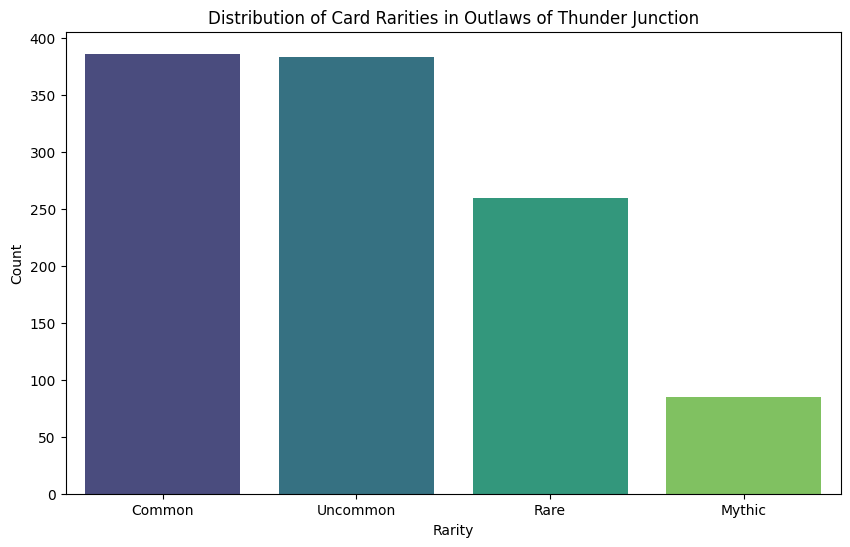

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Zähle die Häufigkeiten der einzelnen Seltenheiten
rarity_counts = data['Rarity'].value_counts().reset_index()
rarity_counts.columns = ['Rarity', 'Count']

# Erstelle das Balkendiagramm
plt.figure(figsize=(10, 6))
sns.barplot(x='Rarity', y='Count', data=rarity_counts, palette='viridis', hue='Rarity', dodge=False, legend=False)
plt.title('Distribution of Card Rarities in Outlaws of Thunder Junction')
plt.xlabel('Rarity')
plt.ylabel('Count')
plt.show()

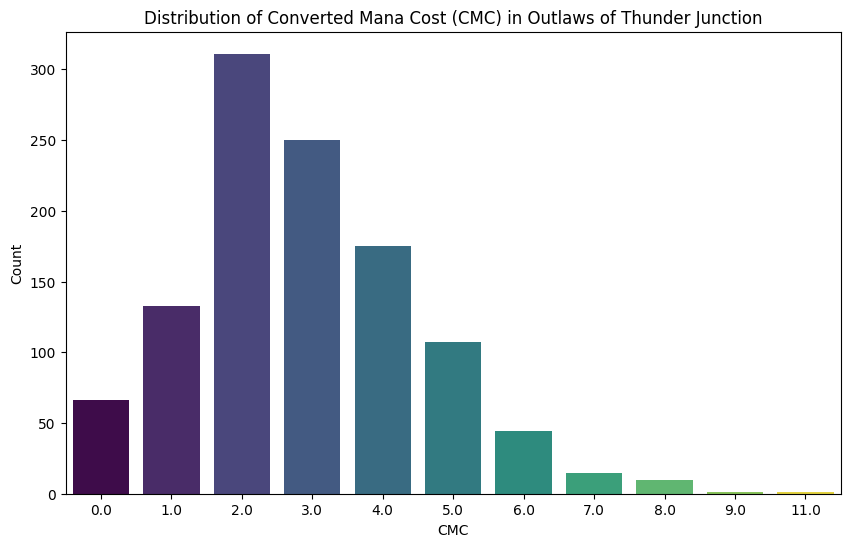

In [ ]:
# Zähle die Häufigkeiten der verschiedenen CMC-Werte
cmc_counts = data['CMC'].value_counts().reset_index()
cmc_counts.columns = ['CMC', 'Count']

# Erstelle das Balkendiagramm
plt.figure(figsize=(10, 6))
sns.barplot(x='CMC', y='Count', data=cmc_counts, palette='viridis', hue='CMC', dodge=False)
plt.legend([],[], frameon=False)
plt.title('Distribution of Converted Mana Cost (CMC) in Outlaws of Thunder Junction')
plt.xlabel('CMC')
plt.ylabel('Count')
plt.show()


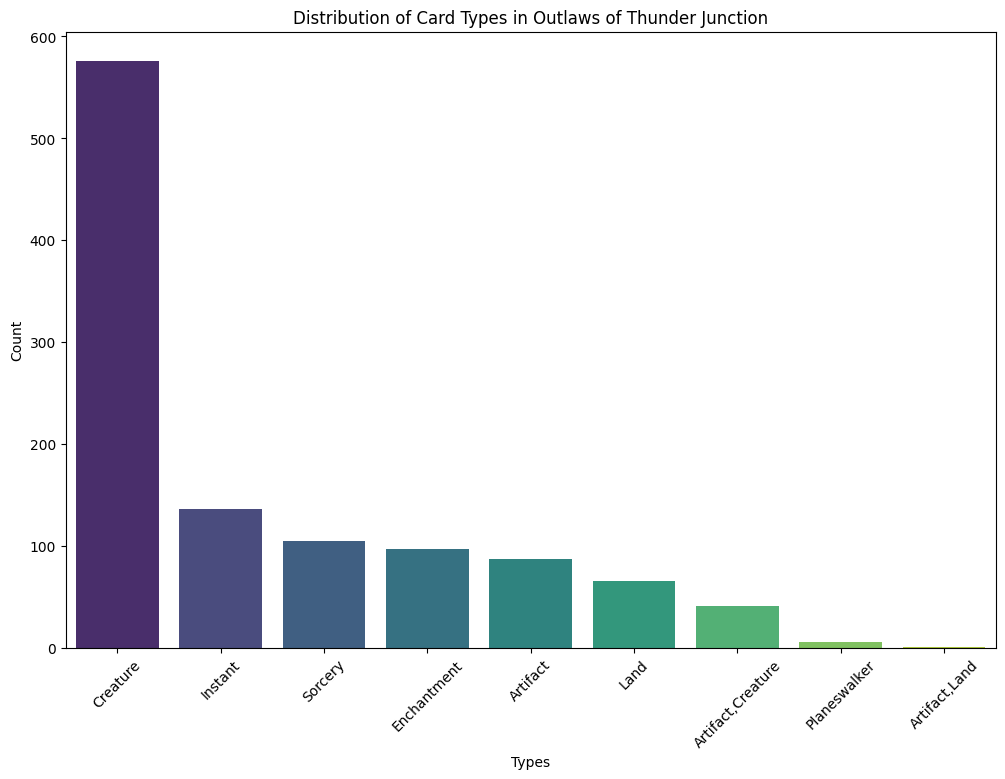

In [ ]:
# Zähle die Häufigkeiten der verschiedenen Types
types_counts = data['Types'].value_counts().reset_index()
types_counts.columns = ['Types', 'Count']

# Erstelle das Balkendiagramm
plt.figure(figsize=(12, 8))
sns.barplot(x='Types', y='Count', data=types_counts, palette='viridis', hue='Types', dodge=False)
plt.legend([],[], frameon=False)
plt.title('Distribution of Card Types in Outlaws of Thunder Junction')
plt.xlabel('Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


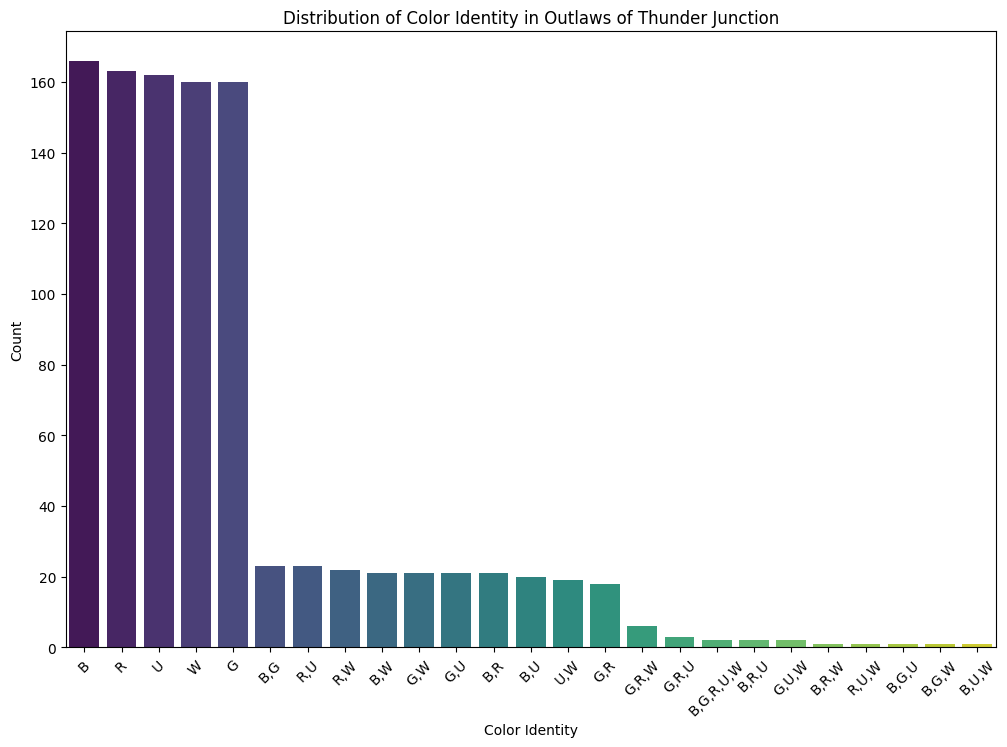

In [ ]:
# Zähle die Häufigkeiten der verschiedenen ColorIdentities
color_identity_counts = data['ColorIdentity'].value_counts().reset_index()
color_identity_counts.columns = ['ColorIdentity', 'Count']

# Erstelle das Balkendiagramm
plt.figure(figsize=(12, 8))
sns.barplot(x='ColorIdentity', y='Count', data=color_identity_counts, palette='viridis', hue='ColorIdentity', dodge=False)
plt.legend([],[], frameon=False)
plt.title('Distribution of Color Identity in Outlaws of Thunder Junction')
plt.xlabel('Color Identity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **4. Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Laden des Datensatzes
data = pd.read_csv('/content/final_combined_sets_cardlist_no_duplicates.csv')

# Entfernen von Zeilen mit fehlenden GIH WR Werten
data = data.dropna(subset=['GIH WR'])

# Konvertieren des GIH WR Wertes in numerischen Wert
data['GIH WR'] = data['GIH WR'].str.rstrip('%').astype('float') / 100.0

# Speichern des Kartennamens
card_names = data['Name']

# Entfernen von nicht benötigten Spalten
data = data.drop(columns=['Name'])

# Auswählen der Merkmale und Zielvariable
X = data.drop(columns=['GIH WR'])
y = data['GIH WR']

# Kategorische Daten kodieren
categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))

# Hinzufügen der numerischen Spalten zu den kodierten Daten
X_encoded.index = X.index
X = X.drop(columns=categorical_columns)
X = pd.concat([X, X_encoded], axis=1)

# Konvertieren aller Spaltennamen in Strings
X.columns = X.columns.astype(str)

# Ersetzen von fehlenden Werten durch den Mittelwert
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test, card_names_train, card_names_test = train_test_split(X, y, card_names, test_size=0.2, random_state=42)




KeyboardInterrupt: 

# **5. Modelltraining**

In [ ]:
# Modelltraining
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersagen auf dem Trainingsset
y_train_pred = model.predict(X_train)

# Vorhersagen auf dem Testset
y_test_pred = model.predict(X_test)


# Modellbewertung
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error (Train): {mse_train}')
print(f'Mean Squared Error (Test): {mse_test}')

# Beispielvorhersagen anzeigen
predictions = pd.DataFrame({
    'Name': card_names_test,
    'Actual': y_test,
    'Predicted': y_test_pred
})
print(predictions.head())


Mean Squared Error (Train): 0.0006537115972873709
Mean Squared Error (Test): 0.0015293844040029007
                        Name  Actual  Predicted
428          Lightning Helix   0.589   0.557457
262  Bloodletter of Aclazotz   0.568   0.566270
338          Slimy Dualleech   0.538   0.528910
653       Take Up the Shield   0.574   0.537800
103         Poetic Ingenuity   0.582   0.547703


R² (Train): 0.615139751749682
R² (Test): 0.10365495536288238


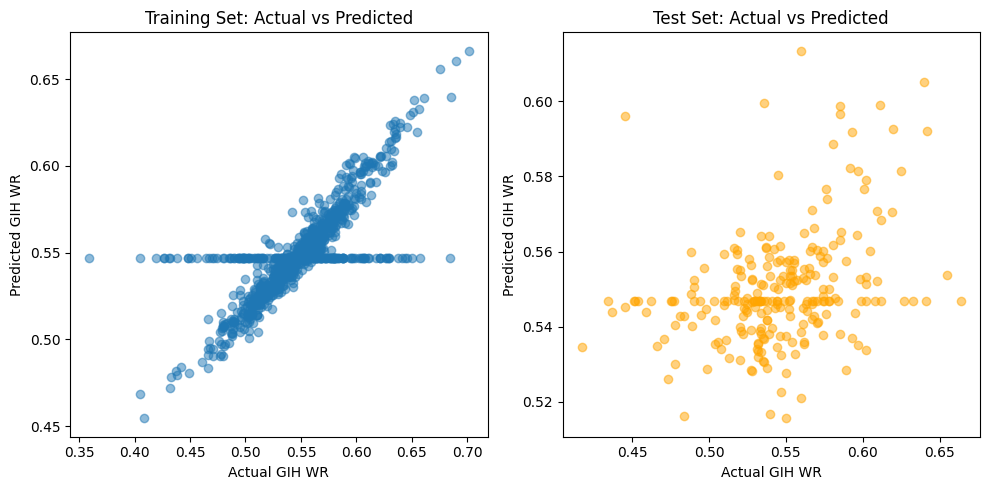

                              Name  Actual  Predicted
428                Lightning Helix   0.589   0.557457
262        Bloodletter of Aclazotz   0.568   0.566270
338                Slimy Dualleech   0.538   0.528910
653             Take Up the Shield   0.574   0.537800
103               Poetic Ingenuity   0.582   0.547703
441    Krenko, Baron of Tin Street   0.585   0.598740
578           Branch of Vitu-Ghazi   0.525   0.544002
247  Captain Storm, Cosmium Raider   0.596   0.564350
80              Rumbling Rockslide   0.539   0.558523
645           The Key to the Vault   0.437   0.543900


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Berechnung des R²-Werts
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R² (Train): {r2_train}')
print(f'R² (Test): {r2_test}')

# Streudiagramm der Vorhersagen
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.title('Training Set: Actual vs Predicted')
plt.xlabel('Actual GIH WR')
plt.ylabel('Predicted GIH WR')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='orange')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual GIH WR')
plt.ylabel('Predicted GIH WR')

plt.tight_layout()
plt.show()

# Beispielvorhersagen anzeigen
predictions = pd.DataFrame({
    'Name': card_names_test,
    'Actual': y_test,
    'Predicted': y_test_pred
})
print(predictions.head(10))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter für RandomizedSearchCV definieren
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV initialisieren
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Hyperparameter-Tuning durchführen
random_search.fit(X_train, y_train)

# Bestes Modell auswählen
best_model = random_search.best_estimator_

# Vorhersagen mit dem besten Modell
y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)

# Modellbewertung
mse_train_best = mean_squared_error(y_train, y_train_pred_best)
mse_test_best = mean_squared_error(y_test, y_test_pred_best)
r2_train_best = r2_score(y_train, y_train_pred_best)
r2_test_best = r2_score(y_test, y_test_pred_best)

# Speichern des Modells, des Encoders und des Imputers
joblib.dump(model, 'best_model.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(imputer, 'imputer.pkl')
joblib.dump(categorical_columns.tolist(), 'categorical_columns.pkl')
joblib.dump(X.columns.tolist(), 'all_columns.pkl')

print(f'Best Mean Squared Error (Train): {mse_train_best}')
print(f'Best Mean Squared Error (Test): {mse_test_best}')
print(f'Best R² (Train): {r2_train_best}')
print(f'Best R² (Test): {r2_test_best}')


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Mean Squared Error (Train): 0.0010484702756265272
Best Mean Squared Error (Test): 0.0014890737611124116
Best R² (Train): 0.38273310090394497
Best R² (Test): 0.1272803074368648


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Modell initialisieren
gbr_model = GradientBoostingRegressor(random_state=42)

# Kreuzvalidierung
cv_scores_gbr = cross_val_score(gbr_model, X, y, cv=5, scoring='r2')
print(f'Cross-validated R² scores (Gradient Boosting): {cv_scores_gbr}')
print(f'Mean Cross-validated R² (Gradient Boosting): {np.mean(cv_scores_gbr)}')

# Modelltraining und Bewertung
gbr_model.fit(X_train, y_train)
y_train_pred_gbr = gbr_model.predict(X_train)
y_test_pred_gbr = gbr_model.predict(X_test)

# Berechnung der Metriken
mse_train_gbr = mean_squared_error(y_train, y_train_pred_gbr)
mse_test_gbr = mean_squared_error(y_test, y_test_pred_gbr)
r2_train_gbr = r2_score(y_train, y_train_pred_gbr)
r2_test_gbr = r2_score(y_test, y_test_pred_gbr)

print(f'Gradient Boosting Mean Squared Error (Train): {mse_train_gbr}')
print(f'Gradient Boosting Mean Squared Error (Test): {mse_test_gbr}')
print(f'Gradient Boosting R² (Train): {r2_train_gbr}')
print(f'Gradient Boosting R² (Test): {r2_test_gbr}')


Cross-validated R² scores (Gradient Boosting): [0.06661196 0.12282409 0.10853658 0.03093421 0.0445541 ]
Mean Cross-validated R² (Gradient Boosting): 0.07469218848468424
Gradient Boosting Mean Squared Error (Train): 0.0011711518371128387
Gradient Boosting Mean Squared Error (Test): 0.0015559354455279464
Gradient Boosting R² (Train): 0.31050666893412526
Gradient Boosting R² (Test): 0.08809386134450514


In [ ]:
import pickle

# Speichern des besten Modells
with open('/content/random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Speichern des Encoders
with open('/content/one_hot_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

# Speichern des Imputers
with open('/content/simple_imputer.pkl', 'wb') as imputer_file:
    pickle.dump(imputer, imputer_file)

In [ ]:
import requests
import pandas as pd
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Funktion zum Abrufen von Karten aus einem bestimmten Set
def get_cards_from_set(set_code):
    url = f"https://api.magicthegathering.io/v1/cards"
    params = {'set': set_code, 'pageSize': 100}
    cards = []
    page = 1

    while True:
        params['page'] = page
        response = requests.get(url, params=params)
        data = response.json()
        cards.extend(data['cards'])

        if len(data['cards']) < 100:
            break

        page += 1

    return cards

# Funktion zum Extrahieren der relevanten Kartendaten
def extract_card_data(card):
    return {
        'Name': card.get('name', ''),
        'ManaCost': card.get('manaCost', ''),
        'CMC': card.get('cmc', ''),
        'Colors': ','.join(card.get('colors', [])),
        'ColorIdentity': ','.join(card.get('colorIdentity', [])),
        'Types': ','.join(card.get('types', [])),
        'Subtypes': ','.join(card.get('subtypes', [])),
        'Text': card.get('text', ''),
        'Rarity': card.get('rarity', ''),
        'Power': card.get('power', ''),
        'Toughness': card.get('toughness', ''),
        'Set': card.get('set', '')
    }

# Abrufen der Daten für das neue Set "MOM"
set_code = "MOM"
mom_cards = get_cards_from_set(set_code)
mom_card_data = [extract_card_data(card) for card in mom_cards]

# Erstellen eines DataFrame aus den MOM-API-Daten
df_mom_api = pd.DataFrame(mom_card_data)

# Laden des trainierten Modells und der Encoder
with open('/content/random_forest_model.pkl', 'rb') as model_file:
    trained_model = pickle.load(model_file)

with open('/content/one_hot_encoder.pkl', 'rb') as encoder_file:
    encoder = pickle.load(encoder_file)

with open('/content/simple_imputer.pkl', 'rb') as imputer_file:
    imputer = pickle.load(imputer_file)

# Vorhersage auf den MOM-Daten
def predict_gih_wr(data, model, encoder, imputer):
    # Kategorische Daten kodieren
    categorical_columns = data.select_dtypes(include=['object']).columns
    data_encoded = pd.DataFrame(encoder.transform(data[categorical_columns]))

    # Hinzufügen der numerischen Spalten zu den kodierten Daten
    data_encoded.index = data.index
    data = data.drop(columns=categorical_columns)
    data = pd.concat([data, data_encoded], axis=1)

    # Konvertieren aller Spaltennamen in Strings
    data.columns = data.columns.astype(str)

    # Ersetzen von fehlenden Werten durch den Mittelwert
    data = pd.DataFrame(imputer.transform(data), columns=data.columns)

    # Vorhersagen
    predictions = model.predict(data)
    return predictions

# Entfernen des Kartennamens
mom_card_names = df_mom_api['Name']
df_mom_api = df_mom_api.drop(columns=['Name'])

# GIH WR Vorhersage für MOM
predicted_gih_wr_mom = predict_gih_wr(df_mom_api, trained_model, encoder, imputer)

# Anzeigen der Vorhersagen
mom_predictions = pd.DataFrame({
    'Name': mom_card_names,
    'Predicted GIH WR': predicted_gih_wr_mom
})

# Laden der tatsächlichen GIH WR Werte für das Set "MOM"
data_mom_actual = pd.read_csv('/content/card-ratings-MOM.csv')

# Kombinieren der vorhergesagten und tatsächlichen Werte
comparison = pd.merge(mom_predictions, data_mom_actual[['Name', 'GIH WR']], on='Name', how='inner')

# Konvertieren des GIH WR Wertes in numerischen Wert
comparison['GIH WR'] = comparison['GIH WR'].str.rstrip('%').astype('float') / 100.0

# Berechnung der Modellbewertung
mse = mean_squared_error(comparison['GIH WR'], comparison['Predicted GIH WR'])
r2 = r2_score(comparison['GIH WR'], comparison['Predicted GIH WR'])

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Gesamte Liste der Vorhersagen und tatsächlichen Werte anzeigen
print(comparison)

# Speichern der Vorhersagen und tatsächlichen Werte in einer CSV-Datei
comparison.to_csv('/content/mom_set_gih_wr_comparison.csv', index=False)


Mean Squared Error: 0.0013646024479568853
R² Score: 0.09521379492933457
                           Name  Predicted GIH WR  GIH WR
0                  Aerial Boost          0.538865   0.575
1    Alabaster Host Intercessor          0.540246   0.547
2     Alabaster Host Sanctifier          0.542189   0.531
3          Angelic Intervention          0.538865   0.564
4             Archangel Elspeth          0.570745   0.618
..                          ...               ...     ...
271             Scoured Barrens          0.544281   0.535
272           Swiftwater Cliffs          0.545138   0.543
273             Thornwood Falls          0.549840   0.547
274               Tranquil Cove          0.544281   0.549
275           Wind-Scarred Crag          0.544281   0.525

[276 rows x 3 columns]


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Laden der tatsächlichen GIH WR Werte für das Set "MOM"
data_mom_actual = pd.read_csv('/content/card-ratings-MOM.csv')

# Kombinieren der vorhergesagten und tatsächlichen Werte
comparison = pd.merge(mom_predictions, data_mom_actual[['Name', 'GIH WR']], on='Name', how='inner')

# Konvertieren des GIH WR Wertes in numerischen Wert
comparison['GIH WR'] = comparison['GIH WR'].str.rstrip('%').astype('float') / 100.0

# Berechnung der Differenz zwischen tatsächlichen und vorhergesagten Werten
comparison['Difference'] = (comparison['Predicted GIH WR'] - comparison['GIH WR']).abs()

# 10 Karten mit den größten Unterschieden
largest_diff = comparison.nlargest(10, 'Difference')

# 10 Karten mit den kleinsten Unterschieden
smallest_diff = comparison.nsmallest(10, 'Difference')

# Ausgabe der Ergebnisse
print("10 Karten mit den größten Unterschieden:")
print(largest_diff)

print("\n10 Karten mit den kleinsten Unterschieden:")
print(smallest_diff)

# Speichern der Ergebnisse in CSV-Dateien
largest_diff.to_csv('/content/mom_set_largest_diff.csv', index=False)
smallest_diff.to_csv('/content/mom_set_smallest_diff.csv', index=False)


10 Karten mit den größten Unterschieden:
                      Name  Predicted GIH WR  GIH WR  Difference
38                 Sunfall          0.535376   0.670    0.134624
39                 Sunfall          0.535376   0.670    0.134624
88   Breach the Multiverse          0.534935   0.650    0.115065
89   Breach the Multiverse          0.534935   0.650    0.115065
250     Yargle and Multani          0.614001   0.511    0.103001
251     Yargle and Multani          0.614001   0.511    0.103001
173       Crystal Carapace          0.546689   0.450    0.096689
114                Pile On          0.522270   0.613    0.090730
115                Pile On          0.522270   0.613    0.090730
238   Omnath, Locus of All          0.585637   0.497    0.088637

10 Karten mit den kleinsten Unterschieden:
                     Name  Predicted GIH WR  GIH WR  Difference
85      Bladed Battle-Fan          0.539162   0.539    0.000162
29    Phyrexian Awakening          0.542680   0.543    0.000320
10      

Mean Squared Error (MSE): 0.0013646024479568853
Mean Absolute Error (MAE): 0.027588450120748897
Root Mean Squared Error (RMSE): 0.036940525821337264
R² Score: 0.09521379492933457


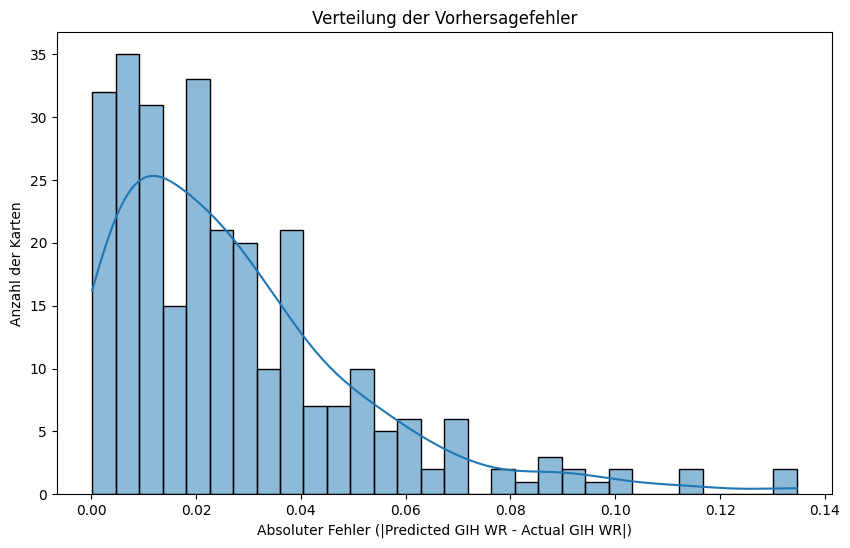

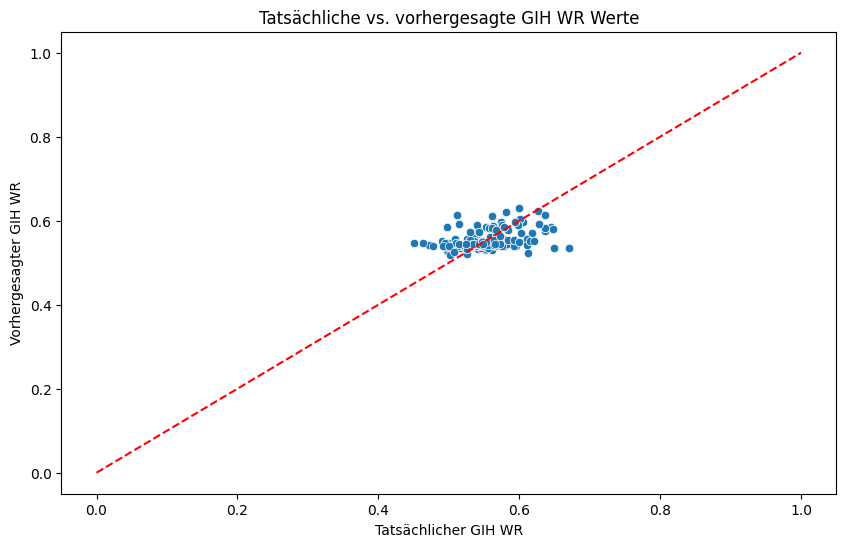

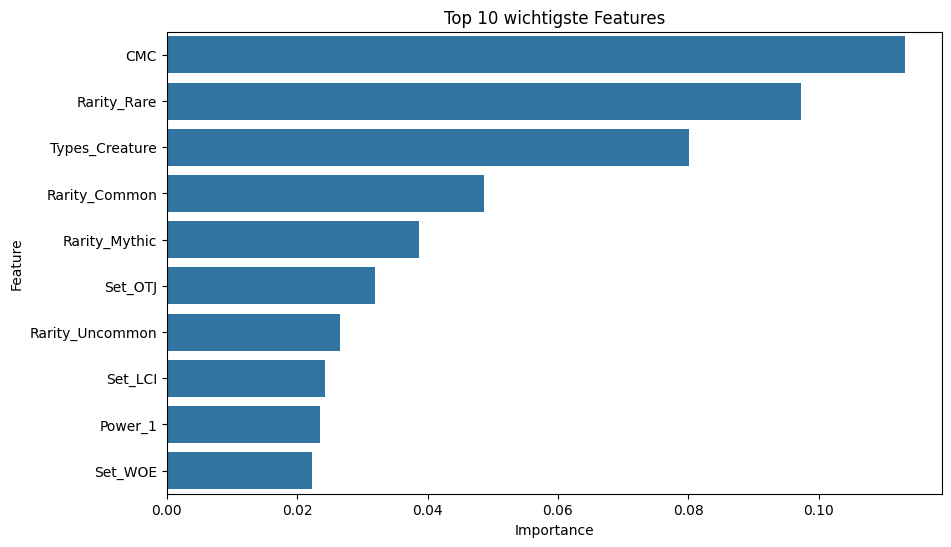

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Kreuzvalidierungs-RMSE: 0.038982231399965414 ± 0.0017766322102809673


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Berechnung zusätzlicher Metriken
mse = mean_squared_error(comparison['GIH WR'], comparison['Predicted GIH WR'])
mae = mean_absolute_error(comparison['GIH WR'], comparison['Predicted GIH WR'])
r2 = r2_score(comparison['GIH WR'], comparison['Predicted GIH WR'])
rmse = mse ** 0.5

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

# Visualisierung der Vorhersagefehler
plt.figure(figsize=(10, 6))
sns.histplot(comparison['Difference'], bins=30, kde=True)
plt.title('Verteilung der Vorhersagefehler')
plt.xlabel('Absoluter Fehler (|Predicted GIH WR - Actual GIH WR|)')
plt.ylabel('Anzahl der Karten')
plt.show()

# Scatterplot der tatsächlichen gegen die vorhergesagten Werte
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison['GIH WR'], y=comparison['Predicted GIH WR'])
plt.plot([0, 1], [0, 1], 'r--')  # Diagonale Linie zum Vergleich
plt.title('Tatsächliche vs. vorhergesagte GIH WR Werte')
plt.xlabel('Tatsächlicher GIH WR')
plt.ylabel('Vorhergesagter GIH WR')
plt.show()

# Feature Importance analysieren
importances = trained_model.feature_importances_
feature_names = X.columns

# Wiederherstellen der ursprünglichen Kategorienamen nach One-Hot-Encoding
encoded_categorical_columns = encoder.get_feature_names_out(categorical_columns)
all_feature_names = list(X.columns[:len(X.columns) - len(encoded_categorical_columns)]) + list(encoded_categorical_columns)

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})

# Wichtigste Features anzeigen
top_features = feature_importance_df.nlargest(10, 'Importance')
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 wichtigste Features')
plt.show()

# Kreuzvalidierung
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(trained_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = (-cv_scores) ** 0.5

print(f'Kreuzvalidierungs-RMSE: {cv_rmse_scores.mean()} ± {cv_rmse_scores.std()}')
